<a href="https://colab.research.google.com/github/Nimsaa/deepfake_thesis/blob/main/thesis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

# Select GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Later: move model and data to this device
model = MyModel().to(device)
inputs = inputs.to(device)
labels = labels.to(device)


Using device: cuda


NameError: name 'MyModel' is not defined

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
#setting up path
base_path = "/content/drive/MyDrive/odss"
natural_path = os.path.join(base_path, "natural")
vits_path = os.path.join(base_path, "vits")

Glob - finds matching patterns , here trying to find all .wav files. . very *.wav wildcard coded.
coolect_wav_files will take 2 inputs , the directory (in this case natural and vits) and then label it 1 or 0





In [ ]:
from glob import glob

def collect_wav_files(root_dir, label):
    data = []
    for dataset in os.listdir(root_dir):
        dataset_path = os.path.join(root_dir, dataset)
        if not os.path.isdir(dataset_path):
            continue
        for speaker in os.listdir(dataset_path):
            speaker_path = os.path.join(dataset_path, speaker)
            wavs = glob(os.path.join(speaker_path, "*.wav"))
            for wav_path in wavs:
                data.append({
                    "speaker": speaker,
                    "dataset": dataset,
                    "path": wav_path,
                    "is_fake": label
                })
    return data

natural_data = collect_wav_files(natural_path, 0)
vits_data = collect_wav_files(vits_path, 1)


In [ ]:
import pandas as pd

speaker_info_path = "/content/drive/MyDrive/odss/speaker_info.csv"  # Update if needed
speaker_info_df = pd.read_csv(speaker_info_path)

In [ ]:

audio_df = pd.DataFrame(natural_data + vits_data)

In [ ]:

merged_df = audio_df.merge(speaker_info_df, on=["speaker", "dataset"], how="left")

In [ ]:
merged_df.tail()


,speaker,dataset,path,is_fake,gender,language
22059,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de
22060,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de
22061,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de
22062,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de
22063,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de


In [ ]:
!pip install praat-parselmouth

In [ ]:
import librosa
import numpy as np
import parselmouth

def extract_features(path):
    features = {}

    y, sr = librosa.load(path, sr=None)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i}_mean'] = np.mean(mfcc[i])
        features[f'mfcc_{i}_std'] = np.std(mfcc[i])

    # Pitch
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_values = pitches[magnitudes > np.median(magnitudes)]
    features['pitch_mean'] = np.mean(pitch_values) if pitch_values.size else 0

    # Speech rate (ZCR)
    zcr = librosa.feature.zero_crossing_rate(y)
    features['speech_rate'] = np.mean(zcr)

    # Parselmouth (jitter, shimmer, HNR, formants)
    snd = parselmouth.Sound(path)

    try:
        pp = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", 75, 500)
        features['jitter'] = parselmouth.praat.call([snd, pp], "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
        features['shimmer'] = parselmouth.praat.call([snd, pp], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    except:
        features['jitter'] = np.nan
        features['shimmer'] = np.nan

    try:
        hnr_obj = parselmouth.praat.call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
        features['hnr'] = parselmouth.praat.call(hnr_obj, "Get mean", 0, 0)
    except:
        features['hnr'] = np.nan

    try:
        formant = parselmouth.praat.call(snd, "To Formant (burg)", 0.02, 5, 5500, 0.025, 50)
        f1_list, f2_list = [], []
        for t in np.arange(0.05, snd.duration, 0.01):  # Avoid time 0
            f1 = parselmouth.praat.call(formant, "Get value at time", 1, t, 'Hertz', 'Linear')
            f2 = parselmouth.praat.call(formant, "Get value at time", 2, t, 'Hertz', 'Linear')
            if f1: f1_list.append(f1)
            if f2: f2_list.append(f2)
        features['F1'] = np.mean(f1_list) if f1_list else np.nan
        features['F2'] = np.mean(f2_list) if f2_list else np.nan
    except:
        features['F1'] = np.nan
        features['F2'] = np.nan

    return features


In [ ]:
# deepcopy for log reg version - using the main df and adding required features for each model separately
log_reg_df = merged_df.copy()

# For new features that will be extracted
feature_columns = []

from tqdm import tqdm

for idx, row in tqdm(log_reg_df.iterrows(), total=len(log_reg_df)):

    try:
        feats = extract_features(row["path"])  # Correct function
        for k, v in feats.items():
            log_reg_df.at[idx, k] = v
            if k not in feature_columns:
                feature_columns.append(k)
    except Exception as e:
        print(f"Error in {row['path']}: {e}")

100%|██████████| 22064/22064 [3:28:26<00:00,  1.76it/s]


In [ ]:
log_reg_df.sample(5)

,speaker,dataset,path,is_fake,gender,language,mfcc_0_mean,mfcc_0_std,mfcc_1_mean,mfcc_1_std,...,mfcc_11_std,mfcc_12_mean,mfcc_12_std,pitch_mean,speech_rate,jitter,shimmer,hnr,F1,F2
18544,p317,vctk,/content/drive/MyDrive/odss/vits/vctk/p317/p31...,1,f,en,-452.209656,164.743179,68.878540,50.012478,...,7.482750,5.475425,6.985565,1954.032349,0.075643,NaN,NaN,12.376199,NaN,NaN
8684,p376,vctk,/content/drive/MyDrive/odss/natural/vctk/p376/...,0,m,en,-427.454468,177.984116,105.119484,38.374992,...,9.045292,0.170788,11.626082,851.715576,0.038292,NaN,NaN,10.004600,NaN,NaN
17888,p263,vctk,/content/drive/MyDrive/odss/vits/vctk/p263/p26...,1,m,en,-440.722504,179.006790,83.991989,69.180504,...,7.661402,5.241793,6.759166,1203.329712,0.042244,NaN,NaN,13.046357,NaN,NaN
15259,6670,hifi-tts,/content/drive/MyDrive/odss/vits/hifi-tts/6670...,1,m,en,-307.678833,141.038925,83.956528,53.497101,...,8.273189,-12.496811,10.712881,1255.044678,0.083181,NaN,NaN,13.920808,NaN,NaN
5725,p304,vctk,/content/drive/MyDrive/odss/natural/vctk/p304/...,0,m,en,-404.294952,163.535797,78.651741,59.326679,...,7.929339,7.800468,6.806385,1535.142700,0.080843,NaN,NaN,8.220338,NaN,NaN


In [ ]:
log_reg_df.to_pickle("log_reg_features.pkl")  # more efficient


In [ ]:
log_reg_df.to_csv("log_reg_features.csv", index=False)


In [ ]:
#PATCHING FROM HERE AS MISSING FEATURES AS NAN VALUES

In [ ]:
import parselmouth
import numpy as np

def extract_voice_quality_features(path):
    features = {}

    try:
        snd = parselmouth.Sound(path)

        try:
            pp = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", 75, 500)
            features['jitter'] = parselmouth.praat.call([snd, pp], "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
            features['shimmer'] = parselmouth.praat.call([snd, pp], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
        except:
            features['jitter'] = np.nan
            features['shimmer'] = np.nan

        try:
            formant = parselmouth.praat.call(snd, "To Formant (burg)", 0.02, 5, 5500, 0.025, 50)
            f1_list, f2_list = [], []
            for t in np.arange(0.05, snd.duration, 0.01):
                f1 = parselmouth.praat.call(formant, "Get value at time", 1, t, 'Hertz', 'Linear')
                f2 = parselmouth.praat.call(formant, "Get value at time", 2, t, 'Hertz', 'Linear')
                if f1: f1_list.append(f1)
                if f2: f2_list.append(f2)
            features['F1'] = np.mean(f1_list) if f1_list else np.nan
            features['F2'] = np.mean(f2_list) if f2_list else np.nan
        except:
            features['F1'] = np.nan
            features['F2'] = np.nan

    except Exception as e:
        print(f"Error in {path}: {e}")
        features = {'jitter': np.nan, 'shimmer': np.nan, 'F1': np.nan, 'F2': np.nan}

    return features


In [ ]:
from tqdm import tqdm

for idx, row in tqdm(log_reg_df.iterrows(), total=len(log_reg_df)):
    if any(pd.isna(row[col]) for col in ['jitter', 'shimmer', 'F1', 'F2']):
        feats = extract_voice_quality_features(row['path'])
        for k, v in feats.items():
            log_reg_df.at[idx, k] = v


100%|██████████| 22064/22064 [1:06:23<00:00,  5.54it/s]


In [ ]:
log_reg_df.sample(5)


NameError: name 'log_reg_df' is not defined

In [ ]:

import pandas as pd

log_reg_df = pd.read_csv("/content/drive/MyDrive/odss/log_reg_features.csv")



In [ ]:
!pip install opensmile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 21.6 MB/s eta 0:00:00


In [ ]:
from opensmile import Smile, FeatureSet, FeatureLevel
import numpy as np
from tqdm import tqdm


In [ ]:


# Initialize openSMILE
smile = Smile(
    feature_set=FeatureSet.ComParE_2016,
    feature_level=FeatureLevel.Functionals
)

# Patch missing jitter and shimmer values using openSMILE
def patch_with_opensmile(path):
    try:
        result = smile.process_file(path)
        row = result.iloc[0]
        jitter = row.get('jitterLocal_sma_linregc2', np.nan)
        shimmer = row.get('shimmerLocal_sma_linregc2', np.nan)
        return jitter, shimmer
    except Exception as e:
        print(f"[x] Failed for {path}: {e}")
        return np.nan, np.nan


In [ ]:
for idx, row in tqdm(log_reg_df.iterrows(), total=len(log_reg_df)):
    if pd.isna(row['jitter']) or pd.isna(row['shimmer']):
        jitter, shimmer = patch_with_opensmile(row['path'])
        log_reg_df.at[idx, 'jitter'] = jitter
        log_reg_df.at[idx, 'shimmer'] = shimmer


100%|██████████| 22064/22064 [5:13:10<00:00,  1.17it/s]


In [ ]:
log_reg_df.tail()

,speaker,dataset,path,is_fake,gender,language,mfcc_0_mean,mfcc_0_std,mfcc_1_mean,mfcc_1_std,...,mfcc_11_std,mfcc_12_mean,mfcc_12_std,pitch_mean,speech_rate,jitter,shimmer,hnr,F1,F2
22059,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-310.93870,120.694990,61.073853,64.459770,...,7.440020,3.355297,6.266328,1775.2618,0.176069,0.073048,0.139288,13.438156,NaN,NaN
22060,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-305.67650,124.017780,66.071620,73.535990,...,7.932513,5.520779,8.687095,1471.0764,0.170039,0.098338,0.223008,12.527261,NaN,NaN
22061,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-294.58383,111.261635,59.541496,57.305347,...,9.059581,4.042005,8.383234,1541.3538,0.169054,0.201576,0.189968,15.453236,NaN,NaN
22062,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-281.68268,140.744750,78.601280,71.481090,...,8.549084,3.425850,7.841340,1611.5330,0.151762,0.084946,0.181492,11.022446,NaN,NaN
22063,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-279.34973,121.508830,69.675600,73.611080,...,8.793427,2.227032,7.677840,1487.1865,0.177178,0.065603,0.154541,12.820001,NaN,NaN


In [ ]:
log_reg_df.to_csv("/content/log_reg_features_patched.csv", index=False)


In [ ]:
from google.colab import files
files.download("/content/log_reg_features_patched.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install praat-parselmouth


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 70.7 MB/s eta 0:00:00


In [ ]:
import librosa
import numpy as np
import scipy.signal

def get_formants_lpc(y, sr):
    try:
        y = y[:int(sr * 0.03)]  # just a slice (30ms)
        n_coeffs = 2 + sr // 1000
        a = scipy.signal.lpc(y, n_coeffs)
        roots = np.roots(a)
        roots = [r for r in roots if np.imag(r) >= 0.01]
        angz = np.arctan2(np.imag(roots), np.real(roots))
        formants = sorted(angz * (sr / (2 * np.pi)))
        return formants[:2] if len(formants) >= 2 else (np.nan, np.nan)
    except Exception as e:
        print("LPC fail:", e)
        return np.nan, np.nan


In [ ]:
y, sr = librosa.load("/content/drive/MyDrive/odss/natural/vctk/p234/p234_054.wav", sr=None)
f1, f2 = get_formants_lpc(y, sr)
print("F1:", f1, "F2:", f2)


LPC fail: module 'scipy.signal' has no attribute 'lpc'
F1: nan F2: nan


In [ ]:
##other approach

import librosa
import numpy as np

def lpc(signal, order):
    # LPC Levinson-Durbin recursion
    from scipy.linalg import solve_toeplitz
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    R = autocorr[:order+1]
    r = R[1:]
    a = solve_toeplitz((R[:-1], R[:-1]), r)
    a = np.concatenate(([1], -a))
    return a


In [ ]:
import scipy.signal

def get_formants_lpc_amateur(y, sr):
    try:
        # Use first 30ms of audio
        y = y[:int(sr * 0.03)]
        y = y * np.hamming(len(y))  # window
        y = y - np.mean(y)

        # LPC order depends on sampling rate
        order = int(2 + sr / 1000)
        a = lpc(y, order)

        # Find roots
        roots = np.roots(a)
        roots = [r for r in roots if np.imag(r) >= 0.01]

        angz = np.arctan2(np.imag(roots), np.real(roots))
        formants = sorted(angz * (sr / (2 * np.pi)))
        return formants[:2] if len(formants) >= 2 else (np.nan, np.nan)
    except Exception as e:
        print("Formant LPC fail:", e)
        return np.nan, np.nan


In [ ]:
y, sr = librosa.load("/content/drive/MyDrive/odss/natural/vctk/p234/p234_054.wav", sr=None)
f1, f2 = get_formants_lpc_amateur(y, sr)
print("F1:", f1)
print("F2:", f2)


🎯 F1: 1184.931422536204
🎯 F2: 1838.4191475662699


In [ ]:
import pandas as pd

log_reg_df = pd.read_csv("/content/drive/MyDrive/odss/log_reg_features.csv")
log_reg_df

,speaker,dataset,path,is_fake,gender,language,mfcc_0_mean,mfcc_0_std,mfcc_1_mean,mfcc_1_std,...,mfcc_11_std,mfcc_12_mean,mfcc_12_std,pitch_mean,speech_rate,jitter,shimmer,hnr,F1,F2
0,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-272.38794,115.978830,97.005030,76.182000,...,12.981519,-12.861583,11.595129,1466.7181,0.130257,NaN,NaN,9.832871,NaN,NaN
1,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-299.20206,148.597900,67.028950,56.052290,...,8.924316,-9.231380,12.028031,1452.8362,0.116930,NaN,NaN,12.636739,NaN,NaN
2,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-271.15112,115.128390,109.935100,61.197582,...,10.310383,-8.451279,12.086157,1236.2042,0.117368,NaN,NaN,10.681270,NaN,NaN
3,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-325.16110,137.085100,71.334390,66.556015,...,11.130038,-8.204823,12.830888,1823.1019,0.125980,NaN,NaN,12.730017,NaN,NaN
4,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-250.64236,104.512190,67.433770,54.104633,...,9.660391,-10.229192,11.922198,1689.7440,0.154225,NaN,NaN,11.085720,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22059,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-310.93870,120.694990,61.073853,64.459770,...,7.440020,3.355297,6.266328,1775.2618,0.176069,NaN,NaN,13.438156,NaN,NaN
22060,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-305.67650,124.017780,66.071620,73.535990,...,7.932513,5.520779,8.687095,1471.0764,0.170039,NaN,NaN,12.527261,NaN,NaN
22061,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-294.58383,111.261635,59.541496,57.305347,...,9.059581,4.042005,8.383234,1541.3538,0.169054,NaN,NaN,15.453236,NaN,NaN
22062,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-281.68268,140.744750,78.601280,71.481090,...,8.549084,3.425850,7.841340,1611.5330,0.151762,NaN,NaN,11.022446,NaN,NaN


In [ ]:
import librosa
import numpy as np

def lpc(signal, order):
    from scipy.linalg import solve_toeplitz
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    R = autocorr[:order+1]
    r = R[1:]
    a = solve_toeplitz((R[:-1], R[:-1]), r)
    a = np.concatenate(([1], -a))
    return a

def get_formants_lpc_amateur(y, sr):
    try:
        y = y[:int(sr * 0.05)]
        y = y * np.hamming(len(y))
        y = y - np.mean(y)

        # Skip if signal is too flat
        if np.std(y) < 1e-5:
            return np.nan, np.nan

        order = int(2 + sr / 1000)
        a = lpc(y, order)

        roots = np.roots(a)
        roots = [r for r in roots if np.imag(r) >= 0.01]
        angz = np.arctan2(np.imag(roots), np.real(roots))
        formants = sorted(angz * (sr / (2 * np.pi)))
        return formants[:2] if len(formants) >= 2 else (np.nan, np.nan)

    except Exception as e:
        print("fail on formants:", e)
        return np.nan, np.nan



In [ ]:
from tqdm import tqdm
import os

In [ ]:
for index, row in tqdm(log_reg_df.iterrows(), total=len(log_reg_df)):
    if pd.isna(row['F1']) or pd.isna(row['F2']):
        file_path = row['path']
        if os.path.exists(file_path):
            try:
                audio_data, sample_rate = librosa.load(file_path, sr=None)
                f1, f2 = get_formants_lpc_amateur(audio_data, sample_rate)
                log_reg_df.at[index, 'F1'] = f1
                log_reg_df.at[index, 'F2'] = f2
            except Exception as error:
                print("Error processing file:", file_path)
                print("Reason:", error)
        else:
            print("File not found:", file_path)


100%|██████████| 22064/22064 [1:20:49<00:00,  4.55it/s]


In [ ]:
log_reg_df

,speaker,dataset,path,is_fake,gender,language,mfcc_0_mean,mfcc_0_std,mfcc_1_mean,mfcc_1_std,...,mfcc_11_std,mfcc_12_mean,mfcc_12_std,pitch_mean,speech_rate,jitter,shimmer,hnr,F1,F2
0,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-272.38794,115.978830,97.005030,76.182000,...,12.981519,-12.861583,11.595129,1466.7181,0.130257,NaN,NaN,9.832871,482.867611,1641.274239
1,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-299.20206,148.597900,67.028950,56.052290,...,8.924316,-9.231380,12.028031,1452.8362,0.116930,NaN,NaN,12.636739,793.978415,1594.566758
2,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-271.15112,115.128390,109.935100,61.197582,...,10.310383,-8.451279,12.086157,1236.2042,0.117368,NaN,NaN,10.681270,1608.138021,1671.665541
3,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-325.16110,137.085100,71.334390,66.556015,...,11.130038,-8.204823,12.830888,1823.1019,0.125980,NaN,NaN,12.730017,647.187769,1268.787594
4,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-250.64236,104.512190,67.433770,54.104633,...,9.660391,-10.229192,11.922198,1689.7440,0.154225,NaN,NaN,11.085720,550.164814,1259.709604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22059,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-310.93870,120.694990,61.073853,64.459770,...,7.440020,3.355297,6.266328,1775.2618,0.176069,NaN,NaN,13.438156,NaN,NaN
22060,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-305.67650,124.017780,66.071620,73.535990,...,7.932513,5.520779,8.687095,1471.0764,0.170039,NaN,NaN,12.527261,NaN,NaN
22061,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-294.58383,111.261635,59.541496,57.305347,...,9.059581,4.042005,8.383234,1541.3538,0.169054,NaN,NaN,15.453236,NaN,NaN
22062,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-281.68268,140.744750,78.601280,71.481090,...,8.549084,3.425850,7.841340,1611.5330,0.151762,NaN,NaN,11.022446,NaN,NaN


In [ ]:
log_reg_df.to_csv("/content/log_reg_features_formants.csv", index=False)


from google.colab import files
files.download("/content/log_reg_features_formants.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

import pandas as pd

# Load the one with jitter, shimmer, HNR
df_jitter_shimmer = pd.read_csv("/content/drive/MyDrive/odss/log_reg_features_patched.csv")



In [ ]:
from google.colab import drive

drive.flush_and_unmount()


In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
os.listdir("/content/drive/MyDrive/odss")


['LICENSE',
 'speaker_info analysis.csv',
 'speaker_info.csv',
 'transcripts.psv',
 'Tab1.twb',
 'fastpitch-hifigan',
 'vits',
 'natural',
 'log_reg_features.csv',
 'log_reg_features_patched.csv',
 'log_reg_features_formants.csv']

In [ ]:
import pandas as pd

# Load both CSVs from Drive
df_jitter_shimmer = pd.read_csv("/content/drive/MyDrive/odss/log_reg_features_patched.csv")
df_formants = pd.read_csv("/content/drive/MyDrive/odss/log_reg_features_formants.csv")

# Merge on 'path'
df_complete = pd.merge(
    df_jitter_shimmer,
    df_formants[['path', 'F1', 'F2']],
    on='path',
    how='left'
)

# Save final version to Drive
df_complete.to_csv("/content/drive/MyDrive/odss/log_reg_features_complete.csv", index=False)


________________________________________________________________________________________________________________________________________________________________


In [ ]:
import pandas as pd
df_complete=pd.read_csv("/content/drive/MyDrive/odss/log_reg_features_complete.csv")


In [ ]:
df_complete

,speaker,dataset,path,is_fake,gender,language,mfcc_0_mean,mfcc_0_std,mfcc_1_mean,mfcc_1_std,...,mfcc_12_std,pitch_mean,speech_rate,jitter,shimmer,hnr,F1_x,F2_x,F1_y,F2_y
0,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-272.38794,115.978830,97.005030,76.182000,...,11.595129,1466.7181,0.130257,0.064248,0.172149,9.832871,NaN,NaN,559.385154,1649.042463
1,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-299.20206,148.597900,67.028950,56.052290,...,12.028031,1452.8362,0.116930,0.006966,0.164342,12.636739,NaN,NaN,794.319768,1584.265895
2,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-271.15112,115.128390,109.935100,61.197582,...,12.086157,1236.2042,0.117368,0.152547,0.280916,10.681270,NaN,NaN,499.772616,1669.927625
3,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-325.16110,137.085100,71.334390,66.556015,...,12.830888,1823.1019,0.125980,0.086650,0.178736,12.730017,NaN,NaN,1207.080864,2238.898504
4,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-250.64236,104.512190,67.433770,54.104633,...,11.922198,1689.7440,0.154225,0.185120,0.296203,11.085720,NaN,NaN,592.331004,1118.893148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22059,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-310.93870,120.694990,61.073853,64.459770,...,6.266328,1775.2618,0.176069,0.073048,0.139288,13.438156,NaN,NaN,722.592263,1631.991611
22060,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-305.67650,124.017780,66.071620,73.535990,...,8.687095,1471.0764,0.170039,0.098338,0.223008,12.527261,NaN,NaN,156.706988,853.565574
22061,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-294.58383,111.261635,59.541496,57.305347,...,8.383234,1541.3538,0.169054,0.201576,0.189968,15.453236,NaN,NaN,793.821791,2039.542725
22062,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-281.68268,140.744750,78.601280,71.481090,...,7.841340,1611.5330,0.151762,0.084946,0.181492,11.022446,NaN,NaN,690.813451,1520.805832


In [ ]:
# Drop old formant columns - EMPTY
df_complete = df_complete.drop(columns=['F1_x', 'F2_x'])

# Rename the good ones
df_complete = df_complete.rename(columns={'F1_y': 'F1', 'F2_y': 'F2'})


In [ ]:
df_complete

,speaker,dataset,path,is_fake,gender,language,mfcc_0_mean,mfcc_0_std,mfcc_1_mean,mfcc_1_std,...,mfcc_11_std,mfcc_12_mean,mfcc_12_std,pitch_mean,speech_rate,jitter,shimmer,hnr,F1,F2
0,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-272.38794,115.978830,97.005030,76.182000,...,12.981519,-12.861583,11.595129,1466.7181,0.130257,0.064248,0.172149,9.832871,559.385154,1649.042463
1,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-299.20206,148.597900,67.028950,56.052290,...,8.924316,-9.231380,12.028031,1452.8362,0.116930,0.006966,0.164342,12.636739,794.319768,1584.265895
2,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-271.15112,115.128390,109.935100,61.197582,...,10.310383,-8.451279,12.086157,1236.2042,0.117368,0.152547,0.280916,10.681270,499.772616,1669.927625
3,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-325.16110,137.085100,71.334390,66.556015,...,11.130038,-8.204823,12.830888,1823.1019,0.125980,0.086650,0.178736,12.730017,1207.080864,2238.898504
4,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Be...,0,m,de,-250.64236,104.512190,67.433770,54.104633,...,9.660391,-10.229192,11.922198,1689.7440,0.154225,0.185120,0.296203,11.085720,592.331004,1118.893148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22059,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-310.93870,120.694990,61.073853,64.459770,...,7.440020,3.355297,6.266328,1775.2618,0.176069,0.073048,0.139288,13.438156,722.592263,1631.991611
22060,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-305.67650,124.017780,66.071620,73.535990,...,7.932513,5.520779,8.687095,1471.0764,0.170039,0.098338,0.223008,12.527261,156.706988,853.565574
22061,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-294.58383,111.261635,59.541496,57.305347,...,9.059581,4.042005,8.383234,1541.3538,0.169054,0.201576,0.189968,15.453236,793.821791,2039.542725
22062,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de,-281.68268,140.744750,78.601280,71.481090,...,8.549084,3.425850,7.841340,1611.5330,0.151762,0.084946,0.181492,11.022446,690.813451,1520.805832


In [ ]:
df_complete.to_csv("/content/drive/MyDrive/odss/log_reg_features_complete.csv", index=False)

In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/odss/log_reg_features_complete.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
selected_features = [
    'pitch_mean', 'speech_rate',
    'mfcc_0_mean', 'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
    'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean',
    'jitter', 'shimmer', 'hnr', 'F1', 'F2'
]



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop rows with missing features and reset index
df_logreg = df_complete.dropna(subset=selected_features).reset_index(drop=True)

# Feature matrix and target
X = df_logreg[selected_features]
y = df_logreg['is_fake']

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split, just X and y
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X_scaled,
    y,
    df_logreg.index,
    test_size=0.2,
    stratify=y,
    random_state=42
)




In [ ]:
meta_test = df_logreg.loc[test_idx, ['speaker', 'dataset', 'path', 'gender', 'language']]


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 1, 0])

In [ ]:
from sklearn.metrics import classification_report

# Show basic metrics
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.65      0.65      0.65      2172
           1       0.65      0.65      0.65      2155

    accuracy                           0.65      4327
   macro avg       0.65      0.65      0.65      4327
weighted avg       0.65      0.65      0.65      4327



In [ ]:
results_df = meta_test.copy()
results_df['y_true'] = y_test.values
results_df['y_pred'] = y_pred


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd

# Define selected features for logistic regression
selected_features = [
    'pitch_mean', 'speech_rate',
    'mfcc_0_mean', 'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
    'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean',
    'jitter', 'shimmer', 'hnr', 'F1', 'F2'
]

# Drop rows with missing values in selected features
df_logreg = df_complete.dropna(subset=selected_features).reset_index(drop=True)

# Extract X (features), y (target), and metadata
X = df_logreg[selected_features]
y = df_logreg['is_fake']
metadata = df_logreg[['speaker', 'dataset', 'path', 'gender', 'language']]

# Normalize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split with stratification
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X_scaled, y, metadata,
    test_size=0.2, stratify=y, random_state=42
)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Create results with true and predicted labels
results_df = meta_test.copy()
results_df['y_true'] = y_test.values
results_df['y_pred'] = y_pred

# Add all feature columns for test set (excluding is_fake)
X_test_df = pd.DataFrame(X_test, columns=selected_features)
results_full = pd.concat([results_df.reset_index(drop=True), X_test_df], axis=1)

# Save to CSV
results_full.to_csv("/content/logreg_test_results.csv", index=False)


In [ ]:
results_full

,speaker,dataset,path,gender,language,y_true,y_pred,pitch_mean,speech_rate,mfcc_0_mean,...,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,jitter,shimmer,hnr,F1,F2
0,Eva_K,hui-acg,/content/drive/MyDrive/odss/natural/hui-acg/Ev...,f,de,0,0,0.603295,1.760988,1.021286,...,-0.368862,-0.355290,-1.006188,-0.002595,0.271944,0.087368,-0.610262,0.511480,0.102536,0.378036
1,p316,vctk,/content/drive/MyDrive/odss/natural/vctk/p316/...,m,en,0,0,-0.859702,-1.144040,-1.046698,...,1.082330,1.144066,0.830770,1.663792,1.191044,-0.529283,1.776886,-1.743518,1.089973,0.973163
2,6671,hifi-tts,/content/drive/MyDrive/odss/natural/hifi-tts/6...,m,en,0,1,1.638079,0.689256,0.984640,...,-1.555542,-1.664594,-0.699397,-2.415226,-0.395460,-0.195853,1.463873,-1.003563,-0.495570,0.664577
3,clm_04310,openslr-es,/content/drive/MyDrive/odss/natural/openslr-es...,m,es,0,0,-0.116078,0.782210,0.485030,...,-0.110151,0.477563,-0.853813,0.258786,0.703951,0.518721,0.170587,-0.394658,-1.011634,-0.422687
4,Karlsson,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Karls...,m,de,1,0,-1.916827,-0.614930,0.348696,...,1.522583,0.073108,1.174314,0.085304,0.787616,-0.659712,0.063412,-0.573994,-0.562081,0.125541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4322,6097,hifi-tts,/content/drive/MyDrive/odss/natural/hifi-tts/6...,m,en,0,0,0.951596,0.914038,0.841350,...,0.411636,-1.448380,-0.598886,-0.821682,1.426741,1.081123,-0.393482,-0.196263,0.145813,0.025241
4323,Bernd_Ungerer,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Bernd...,m,de,1,0,0.830024,0.002754,0.528134,...,0.398140,0.236588,0.341819,0.426253,0.057699,-0.571794,-0.861367,-0.123695,0.143870,0.217839
4324,92,hifi-tts,/content/drive/MyDrive/odss/natural/hifi-tts/9...,f,en,0,0,0.464791,1.184344,0.961532,...,0.122041,-0.067330,0.590605,-1.429451,-0.167884,0.142376,-1.241925,1.318079,0.342662,-1.587937
4325,11614,hifi-tts,/content/drive/MyDrive/odss/vits/hifi-tts/1161...,f,en,1,1,0.282675,-0.523737,0.396668,...,-0.362305,-0.283432,-1.474261,-1.031369,-2.758179,-0.650328,1.054112,0.725170,-0.948929,-0.577839


In [ ]:
from google.colab import files
files.download("/content/logreg_test_results.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
results_full = pd.read_csv("/content/drive/MyDrive/odss/logreg_test_results.csv")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get true and predicted labels
y_true_logreg = results_full["y_true"]
y_pred_logreg = results_full["y_pred"]

# Compute metrics
logreg_metrics = {
    "accuracy": accuracy_score(y_true_logreg, y_pred_logreg),
    "precision": precision_score(y_true_logreg, y_pred_logreg),
    "recall": recall_score(y_true_logreg, y_pred_logreg),
    "f1_score": f1_score(y_true_logreg, y_pred_logreg)
}


In [ ]:
# Save to DataFrame
logreg_metrics_df = pd.DataFrame([logreg_metrics])

# Save to CSV
logreg_metrics_df.to_csv("/content/drive/MyDrive/odss/logreg_evaluation_metrics.csv", index=False)


In [ ]:
summary_by_gender = results_full.groupby('gender').apply(
    lambda g: pd.Series({
        'total': len(g),
        'true_real': ((g['y_true'] == 0) & (g['y_pred'] == 0)).sum(),
        'true_fake': ((g['y_true'] == 1) & (g['y_pred'] == 1)).sum(),
        'false_real': ((g['y_true'] == 1) & (g['y_pred'] == 0)).sum(),
        'false_fake': ((g['y_true'] == 0) & (g['y_pred'] == 1)).sum(),
        'accuracy': (g['y_true'] == g['y_pred']).mean()
    })
).reset_index()

print(summary_by_gender)


  gender   total  true_real  true_fake  false_real  false_fake  accuracy
0      f  2082.0      554.0      826.0       204.0       498.0  0.662824
1      m  2245.0      868.0      568.0       557.0       252.0  0.639644


<ipython-input-16-0876bbb9bacb>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_by_gender = results_full.groupby('gender').apply(


In [ ]:
female = summary_by_gender[summary_by_gender['gender'] == 'f'].iloc[0]
male = summary_by_gender[summary_by_gender['gender'] == 'm'].iloc[0]


likewise i plan to use all metrics here to see their difference.  lower error and higher accuracy . then just conclude which is more biased. very obvious its females here. :)

Accuracy difference between genders: 2.32%


In [ ]:
summary_by_language = results_full.groupby('language').apply(
    lambda g: pd.Series({
        'total': len(g),
        'true_real': ((g['y_true'] == 0) & (g['y_pred'] == 0)).sum(),
        'true_fake': ((g['y_true'] == 1) & (g['y_pred'] == 1)).sum(),
        'false_real': ((g['y_true'] == 1) & (g['y_pred'] == 0)).sum(),
        'false_fake': ((g['y_true'] == 0) & (g['y_pred'] == 1)).sum(),
        'accuracy': (g['y_true'] == g['y_pred']).mean()
    })
).reset_index()

print(summary_by_language)


  language   total  true_real  true_fake  false_real  false_fake  accuracy
0       de   739.0      329.0      177.0       182.0        51.0  0.684709
1       en  2679.0      709.0      879.0       457.0       634.0  0.592758
2       es   909.0      384.0      338.0       122.0        65.0  0.794279


<ipython-input-17-1eac50f7edc9>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_by_language = results_full.groupby('language').apply(


In [ ]:
threshold = 0.05  # 5% threshold for potential bias

max_acc = summary_by_language.loc[summary_by_language['accuracy'].idxmax()]
min_acc = summary_by_language.loc[summary_by_language['accuracy'].idxmin()]

accuracy_gap = abs(max_acc['accuracy'] - min_acc['accuracy'])

print(f"\nHighest accuracy: {max_acc['language']} = {max_acc['accuracy']:.2%}")
print(f"Lowest accuracy:  {min_acc['language']} = {min_acc['accuracy']:.2%}")
print(f"Accuracy gap: {accuracy_gap:.2%}")

if accuracy_gap > threshold:
    print("The difference in accuracy across languages exceeds the threshold. This may indicate bias.")
else:
    print("The accuracy difference across languages is within acceptable limits.")



Highest accuracy: es = 79.43%
Lowest accuracy:  en = 59.28%
Accuracy gap: 20.15%
The difference in accuracy across languages exceeds the threshold. This may indicate bias.


In [ ]:
# Add model tag
summary_by_gender['model'] = 'logistic_regression'
summary_by_language['model'] = 'logistic_regression'

# Save to CSV
summary_by_gender.to_csv("/content/summary_by_gender_logreg.csv", index=False)
summary_by_language.to_csv("/content/summary_by_language_logreg.csv", index=False)

In [ ]:
from google.colab import files
files.download("/content/summary_by_gender_logreg.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("/content/summary_by_language_logreg.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd

# Assuming model is the trained logistic regression model
# And X_test is your test set used in training
feature_names = X.columns if isinstance(X, pd.DataFrame) else list(selected_features)

coeffs = model.coef_[0]
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coeffs,
    'abs_importance': np.abs(coeffs)
}).sort_values(by='abs_importance', ascending=False)

print(importance_df)


        feature  coefficient  abs_importance
2   mfcc_0_mean    -0.805780        0.805780
1   speech_rate    -0.459851        0.459851
3   mfcc_1_mean    -0.458171        0.458171
10  mfcc_8_mean    -0.341210        0.341210
5   mfcc_3_mean    -0.222098        0.222098
13      shimmer    -0.181019        0.181019
9   mfcc_7_mean    -0.130798        0.130798
11  mfcc_9_mean    -0.124420        0.124420
8   mfcc_6_mean    -0.067513        0.067513
12       jitter    -0.056528        0.056528
7   mfcc_5_mean    -0.054097        0.054097
14          hnr    -0.029757        0.029757
6   mfcc_4_mean     0.026722        0.026722
0    pitch_mean     0.024213        0.024213
4   mfcc_2_mean    -0.023580        0.023580
16           F2     0.003293        0.003293
15           F1     0.000465        0.000465


In [ ]:
importance_df.to_csv("/content/Feature_importance_logreg.csv", index=False)

In [ ]:
from google.colab import files
files.download("/content/Feature_importance_logreg.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

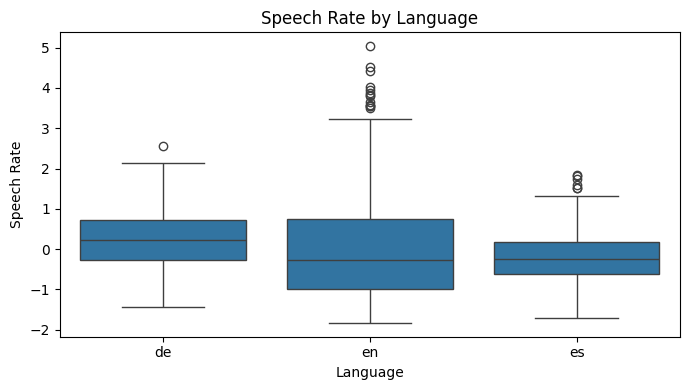

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# English, German, and Spanish
subset = results_full[results_full['language'].isin(['en', 'de', 'es'])]

# speech rate per language
plt.figure(figsize=(7, 4))
sns.boxplot(data=subset, x='language', y='speech_rate')
plt.title("Speech Rate by Language")
plt.ylabel("Speech Rate")
plt.xlabel("Language")
plt.tight_layout()
plt.show()



https://digitalcommons.lindenwood.edu/cgi/viewcontent.cgi?article=1215&context=psych_journals         BUT NEED TO FIND BETTER SOURCE


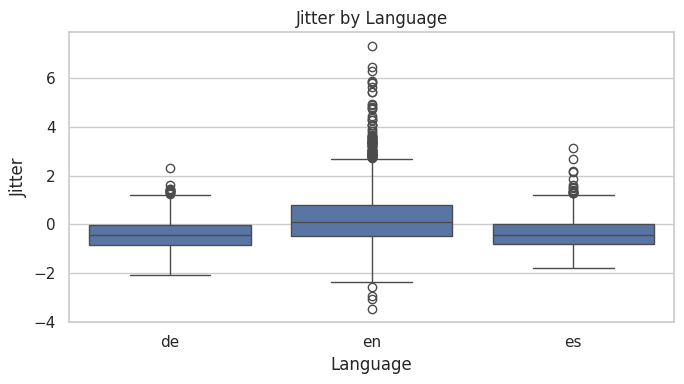

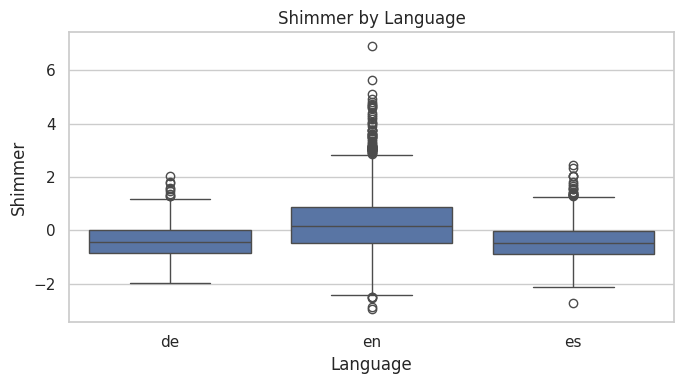

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for English, German, Spanish
subset_langs = ['en', 'de', 'es']
subset = results_full[results_full['language'].isin(subset_langs)]

sns.set(style="whitegrid")

# Jitter plot
plt.figure(figsize=(7, 4))
sns.boxplot(data=subset, x='language', y='jitter')
plt.title("Jitter by Language")
plt.ylabel("Jitter")
plt.xlabel("Language")
plt.tight_layout()
plt.show()

# Shimmer plot
plt.figure(figsize=(7, 4))
sns.boxplot(data=subset, x='language', y='shimmer')
plt.title("Shimmer by Language")
plt.ylabel("Shimmer")
plt.xlabel("Language")
plt.tight_layout()
plt.show()


https://pmc.ncbi.nlm.nih.gov/articles/PMC9443584/   


____________________________________CNN____________________



In [ ]:
merged_df.tail()

,speaker,dataset,path,is_fake,gender,language
22059,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de
22060,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de
22061,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de
22062,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de
22063,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,1,f,de


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa

# Patch numpy for compatibility
np.complex = complex

# Function to extract log-mel spectrogram
def extract_log_mel_spectrogram(path, sr=22050, n_mels=128, duration=3):
    try:
        y, _ = librosa.load(path, sr=sr, duration=duration)
        if len(y) < sr * duration:
            padding = sr * duration - len(y)
            y = np.pad(y, (0, int(padding)), mode='constant')
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=512)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        return log_mel_spec
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

# Output directory
output_dir = "/content/drive/MyDrive/odss/cnn_spectrograms"
os.makedirs(output_dir, exist_ok=True)

cnn_metadata = []

for idx, row in tqdm(merged_df.iterrows(), total=len(merged_df)):
    path = row['path']
    spec = extract_log_mel_spectrogram(path)
    if spec is not None:
        filename = f"spec_{idx}.npy"
        spec_path = os.path.join(output_dir, filename)
        np.save(spec_path, spec)

        cnn_metadata.append({
            "path": path,
            "spec_path": spec_path,
            "is_fake": row['is_fake'],
            "speaker": row['speaker'],
            "dataset": row['dataset'],
            "gender": row.get('gender'),
            "language": row.get('language')
        })

# Save metadata CSV
metadata_csv_path = "/content/drive/MyDrive/odss/cnn_metadata.csv"
pd.DataFrame(cnn_metadata).to_csv(metadata_csv_path, index=False)

metadata_csv_path, output_dir


100%|██████████| 22064/22064 [2:47:32<00:00,  2.19it/s]


('/content/drive/MyDrive/odss/cnn_metadata.csv',
 '/content/drive/MyDrive/odss/cnn_spectrograms')

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import pandas as pd

class SpectrogramDataset(Dataset):
    def __init__(self, metadata_csv):
        self.data = pd.read_csv(metadata_csv)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        spec_path = self.data.iloc[idx]['spec_path']
        label = self.data.iloc[idx]['is_fake']

        # Load spectrogram and normalize
        spec = np.load(spec_path)
        spec = (spec - np.mean(spec)) / np.std(spec)
        spec = np.expand_dims(spec, axis=0)  # Make shape: (1, 128, 130)

        return torch.tensor(spec, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


In [4]:
dataset = SpectrogramDataset("/content/drive/MyDrive/odss/cnn_metadata.csv")
x, y = dataset[0]
print(x.shape, y)  # looking for something like : torch.Size([1, 128, 130]) tensor(0.) or tensor(1.)


torch.Size([1, 128, 130]) tensor(0.)


In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

# Load the full dataset
dataset = SpectrogramDataset("/content/drive/MyDrive/odss/cnn_metadata.csv")

# Split into training and test sets
train_idx, test_idx = train_test_split(
    list(range(len(dataset))), test_size=0.2, random_state=42
)

# Create DataLoaders
train_loader = DataLoader(Subset(dataset, train_idx), batch_size=16, shuffle=True)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=16, shuffle=False)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # (1, 128, 130) → (16, 128, 130)
        self.pool = nn.MaxPool2d(2, 2)                            # → (16, 64, 65)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # → (32, 64, 65) → (32, 32, 32)

        self.fc1 = nn.Linear(32 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 1)  # Output a single value for binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B, 16, 64, 65)
        x = self.pool(F.relu(self.conv2(x)))  # (B, 32, 32, 32)
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))        # Output between 0 and 1
        return x


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AudioCNN().to(device)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [9]:
from tqdm import tqdm

# Set number of epochs
epochs = 5

print(f"Starting training for {epochs} epochs...\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Progress bar for each epoch
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for inputs, labels in loop:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Average Loss: {avg_loss:.4f}")

# Save model after training
model_path = "/content/drive/MyDrive/odss/cnn_model.pth"
torch.save(model.state_dict(), model_path)
print(f"\nTraining complete. Model saved to: {model_path}")


Starting training for 5 epochs...



[Epoch 1] Average Loss: 0.4213


[Epoch 2] Average Loss: 0.1769


[Epoch 3] Average Loss: 0.0992


[Epoch 4] Average Loss: 0.0569


[Epoch 5] Average Loss: 0.0420

Training complete. Model saved to: /content/drive/MyDrive/odss/cnn_model.pth


As I am only using MEL Spectrogram for CNN , i am usinf a saliency map to identify what are the areas of interest : https://en.wikipedia.org/wiki/Saliency_map#:~:text=In%20computer%20vision%2C%20a%20saliency,an%20otherwise%20opaque%20ML%20model.

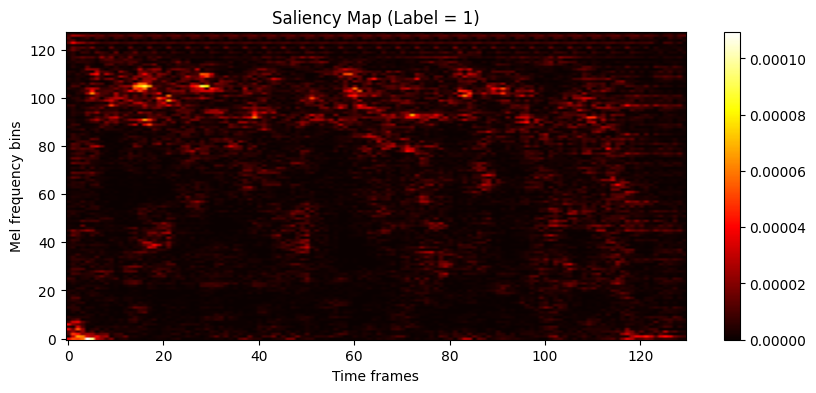

In [11]:
import torch
import matplotlib.pyplot as plt

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Get a sample and move to device
spec, label = dataset[test_idx[0]]
input_tensor = spec.unsqueeze(0).to(device).requires_grad_()

# Forward pass
output = model(input_tensor)
output.backward()

#saliency map
saliency = input_tensor.grad.abs().squeeze().cpu().numpy()

# Plot
plt.figure(figsize=(10, 4))
plt.imshow(saliency, cmap='hot', aspect='auto', origin='lower')
plt.title(f"Saliency Map (Label = {int(label.item())})")
plt.xlabel("Time frames")
plt.ylabel("Mel frequency bins")
plt.colorbar()
plt.show()


we can see the top  100-120 bins are having high saliency . possible error areas found around fake audio, maybe noise or even irregularities in pitch. Higher frequencies seem to be the point to catch the fake from the real.

In [ ]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))


Accuracy: 0.9569453886245185
Precision: 0.9423334823424229
Recall: 0.9718764407561088
F1 Score: 0.9568769859282796


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "precision": precision_score(y_true, y_pred),
    "recall": recall_score(y_true, y_pred),
    "f1_score": f1_score(y_true, y_pred)
}

# Convert to DataFrame and save
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/content/drive/MyDrive/odss/cnn_evaluation_metrics.csv", index=False)


In [ ]:
cnn_meta = pd.read_csv("/content/drive/MyDrive/odss/cnn_metadata.csv")

In [ ]:
# Assuming y_true and y_pred are lists, and test_idx still exists
cnn_test_df = cnn_meta.iloc[test_idx].copy().reset_index(drop=True)
cnn_test_df["y_true"] = y_true
cnn_test_df["y_pred"] = y_pred


In [ ]:
columns_order = [
    "speaker", "dataset", "path", "gender", "language",
    "y_true", "y_pred",
    "pitch_mean", "speech_rate"
] + [f"mfcc_{i}_mean" for i in range(10)] + ["jitter", "shimmer", "hnr", "F1", "F2"]

final_columns = [col for col in columns_order if col in cnn_test_df.columns]
cnn_test_results_df = cnn_test_df[final_columns]


In [ ]:
cnn_test_results_df


,speaker,dataset,path,gender,language,y_true,y_pred
0,pem_03397,openslr-es,/content/drive/MyDrive/odss/vits/openslr-es/pe...,m,es,[1.0],[1.0]
1,12787,hifi-tts,/content/drive/MyDrive/odss/natural/hifi-tts/1...,f,en,[0.0],[0.0]
2,p259,vctk,/content/drive/MyDrive/odss/vits/vctk/p259/p25...,m,en,[1.0],[1.0]
3,cof_07508,openslr-es,/content/drive/MyDrive/odss/natural/openslr-es...,f,es,[0.0],[0.0]
4,p259,vctk,/content/drive/MyDrive/odss/vits/vctk/p259/p25...,m,en,[1.0],[1.0]
...,...,...,...,...,...,...,...
4408,Hokuspokus,hui-acg,/content/drive/MyDrive/odss/vits/hui-acg/Hokus...,f,de,[1.0],[1.0]
4409,12787,hifi-tts,/content/drive/MyDrive/odss/vits/hifi-tts/1278...,f,en,[1.0],[1.0]
4410,vem_09334,openslr-es,/content/drive/MyDrive/odss/natural/openslr-es...,m,es,[0.0],[0.0]
4411,p294,vctk,/content/drive/MyDrive/odss/vits/vctk/p294/p29...,f,en,[1.0],[1.0]


In [ ]:
cnn_test_results_df.to_csv("/content/drive/MyDrive/odss/cnn_test_results.csv", index=False)


In [ ]:
summary_by_gender_CNN = cnn_test_results_df.groupby('gender').apply(
    lambda g: pd.Series({
        'total': len(g),
        'true_real': ((g['y_true'] == 0) & (g['y_pred'] == 0)).sum(),
        'true_fake': ((g['y_true'] == 1) & (g['y_pred'] == 1)).sum(),
        'false_real': ((g['y_true'] == 1) & (g['y_pred'] == 0)).sum(),
        'false_fake': ((g['y_true'] == 0) & (g['y_pred'] == 1)).sum(),
        'accuracy': (g['y_true'] == g['y_pred']).mean()
    })
).reset_index()


<ipython-input-56-d76ba045be5e>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_by_gender_CNN = cnn_test_results_df.groupby('gender').apply(


In [ ]:
summary_by_gender_CNN

,gender,total,true_real,true_fake,false_real,false_fake,accuracy
0,f,2228.0,1052.0,1091.0,21.0,64.0,0.961849
1,m,2185.0,1063.0,1017.0,40.0,65.0,0.951945


In [ ]:
summary_by_gender_CNN.to_csv("/content/drive/MyDrive/odss/summary_by_gender_CNN.csv", index=False)

In [ ]:
summary_by_language_CNN= cnn_test_results_df.groupby('language').apply(
    lambda g: pd.Series({
        'total': len(g),
        'true_real': ((g['y_true'] == 0) & (g['y_pred'] == 0)).sum(),
        'true_fake': ((g['y_true'] == 1) & (g['y_pred'] == 1)).sum(),
        'false_real': ((g['y_true'] == 1) & (g['y_pred'] == 0)).sum(),
        'false_fake': ((g['y_true'] == 0) & (g['y_pred'] == 1)).sum(),
        'accuracy': (g['y_true'] == g['y_pred']).mean()
    })
).reset_index()


<ipython-input-60-c7f01a91c861>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_by_language_CNN= cnn_test_results_df.groupby('language').apply(


In [ ]:
summary_by_language_CNN

,language,total,true_real,true_fake,false_real,false_fake,accuracy
0,de,715.0,308.0,354.0,21.0,32.0,0.925874
1,en,2829.0,1367.0,1358.0,14.0,90.0,0.963238
2,es,869.0,440.0,396.0,26.0,7.0,0.962025


from matplotlib import pyplot as plt
summary_by_language_CNN['total'].plot(kind='hist', bins=20, title='total')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_by_language_CNN['true_real'].plot(kind='hist', bins=20, title='true_real')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_by_language_CNN['true_fake'].plot(kind='hist', bins=20, title='true_fake')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_by_language_CNN['false_real'].plot(kind='hist', bins=20, title='false_real')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
summary_by_language_CNN.groupby('language').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_by_language_CNN.plot(kind='scatter', x='total', y='true_real', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_by_language_CNN.plot(kind='scatter', x='true_real', y='true_fake', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_by_language_CNN.plot(kind='scatter', x='true_fake', y='false_real', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_by_language_CNN.plot(kind='scatter', x='false_real', y='false_fake', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_by_language_CNN['total'].plot(kind='line', figsize=(8, 4), title='total')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary_by_language_CNN['true_real'].plot(kind='line', figsize=(8, 4), title='true_real')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary_by_language_CNN['true_fake'].plot(kind='line', figsize=(8, 4), title='true_fake')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary_by_language_CNN['false_real'].plot(kind='line', figsize=(8, 4), title='false_real')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary_by_language_CNN['language'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary_by_language_CNN, x='total', y='language', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary_by_language_CNN['language'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary_by_language_CNN, x='true_real', y='language', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary_by_language_CNN['language'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary_by_language_CNN, x='true_fake', y='language', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary_by_language_CNN['language'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary_by_language_CNN, x='false_real', y='language', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['total'].plot(kind='hist', bins=20, title='total')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['true_real'].plot(kind='hist', bins=20, title='true_real')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['true_fake'].plot(kind='hist', bins=20, title='true_fake')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('language').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='total', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='total', y='true_real', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='true_real', y='true_fake', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='true_fake', y='false_real', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['total']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('language')):
  _plot_series(series, series_name, i)
  fig.legend(title='language', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('total')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['true_real']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('language')):
  _plot_series(series, series_name, i)
  fig.legend(title='language', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('true_real')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['true_fake']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('language')):
  _plot_series(series, series_name, i)
  fig.legend(title='language', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('true_fake')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['false_real']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('language')):
  _plot_series(series, series_name, i)
  fig.legend(title='language', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('false_real')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['total'].plot(kind='line', figsize=(8, 4), title='total')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['true_real'].plot(kind='line', figsize=(8, 4), title='true_real')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['true_fake'].plot(kind='line', figsize=(8, 4), title='true_fake')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['language'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='language', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['language'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='total', y='language', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['language'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='true_real', y='language', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['language'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='true_fake', y='language', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
summary_by_language_CNN.to_csv("/content/drive/MyDrive/odss/summary_by_language_CNN.csv", index=False)
